# **CRY ANALYSIS**
* ## Machine Learning Model to classify the reasons for infant cries **(Tired ,Discomfort ,Burping ,Belly pain)** with a high degree of accuracy using Convolutional Neural Network 'CNN'.

## Import Modules

In [1]:
import json
import onnx
import keras2onnx
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

#SageMaker Modules
import boto3
import IPython
import sagemaker
from ipywidgets import Dropdown
from sagemaker import image_uris
from sagemaker.model import Model
from sagemaker import get_execution_role
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base
from sagemaker import image_uris, model_uris, script_uris

# SageMaker Service 
## It is a service in Amazon Web Services to provide a cloud platform for machine-learning.

In [ ]:
sess = sagemaker.Session()
aws_role = get_execution_role()
aws_region = boto3.Session().region_name

bucket= 'radi'
prefix = '4classes'
data_location = 's3://{}/{}'.format(bucket, prefix)

training_image = image_uris.retrieve(
    region=boto3.Session().region_name, framework="image-classification"
)

# Define Constants

In [ ]:
IMAGE_WIDTH=400
IMAGE_HEIGHT=400
IMAGE_CHANNELS=3
FAST_RUN = False
EPOCHS=3 if FAST_RUN else 50
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Build Model

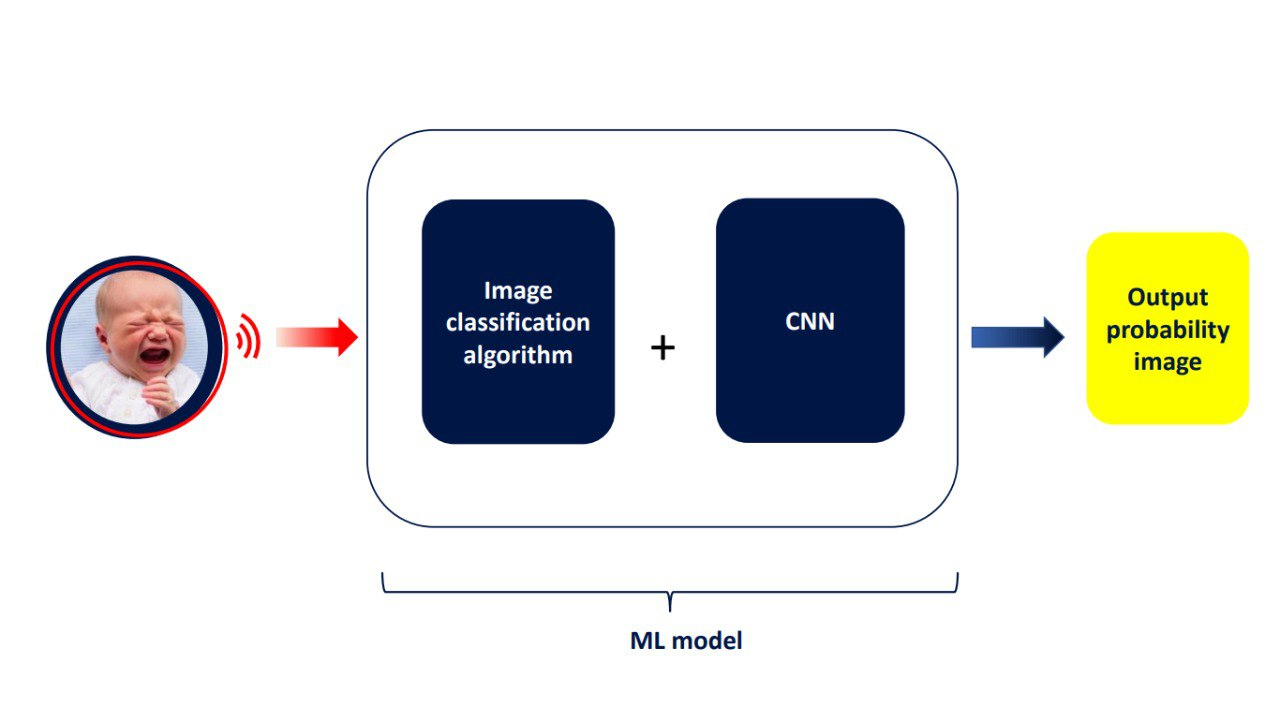

In [1]:
from IPython import display
display.Image(f"{data_location}/BuildModel.jpg")

In [3]:
# download model_manifest file.
boto3.client("s3").download_file(
    f"cache-prod-{aws_region}", "models_manifest.json", "models_manifest.json"
)
with open("models_manifest.json", "rb") as json_file:
    model_list = json.load(json_file)

# filter-out all the Image Classification models from the manifest list.
ic_models_all_versions, ic_models = [
    model["model_id"] for model in model_list if "-ic-" in model["model_id"]
], []
[ic_models.append(model) for model in ic_models_all_versions if model not in ic_models]

# display the model-ids in a dropdown, for user to select a model.
dropdown = Dropdown(
    options=ic_models,
    description="Image Classification Models:",
    style={"description_width": "initial"},
    layout={"width": "max-content"},
)

# model_version="*" fetches the latest version of the model.
infer_model_id, infer_model_version = dropdown.value, "*"

endpoint_name = name_from_base(f"infant-{infer_model_id}")

inference_instance_type = "ml.m5.xlarge"

# Retrieve the inference docker container uri.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=infer_model_id,
    model_version=infer_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri.
deploy_source_uri = script_uris.retrieve(
    model_id=infer_model_id, model_version=infer_model_version, script_scope="inference"
)
# Retrieve the base model uri.
base_model_uri = model_uris.retrieve(
    model_id=infer_model_id, model_version=infer_model_version, model_scope="inference"
)
# Create the SageMaker model instance.
model = Model(
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    model_data=base_model_uri,
    entry_point="inference.py",
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
)

# Callbacks

**Early Stop**

To prevent over fitting we will stop the learning after 5 epochs and val_loss value not decreased

In [10]:
earlystop = EarlyStopping(monitor="accuracy",
                          min_delta=0.01,
                          patience=5,
                          verbose=1 )

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', 
                                            min_lr=0.00001,
                                            patience=2, 
                                            verbose=1)

**Model Check point**

We will save the best weights when the validation accuracy not increase

In [ ]:
modelCheckpoint=  ModelCheckpoint(filepath="models/best_validation_4classes_model.h5",
                                  monitor="val_accuracy",
                                  save_best_only=True,
                                  verbose=1)

# Training Generator

In [4]:
train_generator = ImageDataGenerator( rescale = 1.0/255.).flow_from_directory(
    f'{data_location}/data_set/train_data',
    target_size=IMAGE_SIZE,
    class_mode='categorical')

Found 247 images belonging to 4 classes.


# Fit Model

In [22]:
model.fit(
    train_generator,
    epochs=EPOCHS,
    callbacks = [modelCheckpoint, earlystop, learning_rate_reduction]
)

Epoch 1/50
1333/1333 [==============================] - 2396s 2s/step - loss: 0.7447 - accuracy: 0.6338 - val_loss: 0.5509 - val_accuracy: 0.7273 - lr: 0.0010
Epoch 2/50
1333/1333 [==============================] - 4777s 4s/step - loss: 0.5620 - accuracy: 0.7171 - val_loss: 0.4712 - val_accuracy: 0.7836 - lr: 0.0010
Epoch 3/50
1333/1333 [==============================] - 2395s 2s/step - loss: 0.5051 - accuracy: 0.7623 - val_loss: 0.4593 - val_accuracy: 0.7734 - lr: 0.0010
Epoch 4/50
1333/1333 [==============================] - 2695s 2s/step - loss: 0.4630 - accuracy: 0.7866 - val_loss: 0.4708 - val_accuracy: 0.7772 - lr: 0.0010
Epoch 5/50
1333/1333 [==============================] - 2066s 2s/step - loss: 0.4382 - accuracy: 0.7990 - val_loss: 0.5231 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 6/50
1333/1333 [==============================] - 1731s 1s/step - loss: 0.4174 - accuracy: 0.8152 - val_loss: 0.5657 - val_accuracy: 0.7972 - lr: 0.0010
Epoch 7/50
1333/1333 [========================

# Save Model

In [23]:
model.save( f'{data_location}/models/4classes_model.h5', overwrite=True)
model.save_weights( f'{data_location}/models/weights_4classes_model.h5')
history = model.history.history

# Virtualize Training

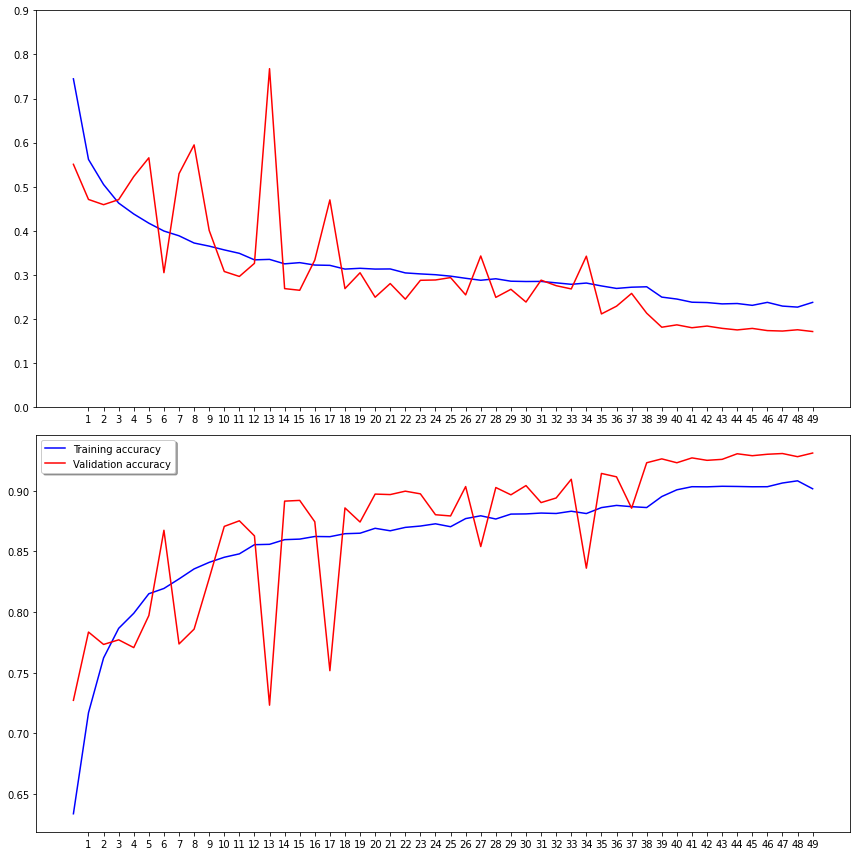

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history['loss'], color='b', label="Training loss")
ax1.plot(history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()
plt.savefig('models/loss_accuracy.png', bbox_inches='tight')
plt.savefig('models/loss_accuracy.pdf', bbox_inches='tight')

# Testing Generator

In [20]:
test_generator = ImageDataGenerator( rescale = 1.0/255.).flow_from_directory(
     f'{data_location}/data_set/test_data',
    target_size=IMAGE_SIZE,
    class_mode='categorical')

Found 247 images belonging to 4 classes.


# Evaluate

In [2]:
model = load_model( f'{data_location}/models/4classes_model.h5')
loss, acc = model.evaluate(test_generator, verbose=2)

4/4 - 14s - loss: 0.3189 - accuracy: 0.8987 - 14s/epoch - 4s/step


# Convert to ONNX File

In [ ]:
backend_model = keras2onnx.convert_keras(model, model.name)
onnx.save_model(backend_model,  f'{data_location}/models/4classes_model.onnx')